In [1]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import mylib
from tqdm import tqdm
from importlib import reload
import pymaster as nmt
import mylib
import scipy as sp

In [2]:
nside = 64
lmax = 3*nside - 1
npix = 12 * nside**2

ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
c2d = ell_input*(ell_input+1)/2/np.pi
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= c2d 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
c2d = c2d[:lmax+1]

input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

/tmp/ipykernel_33786/2683991982.py:9: RuntimeWarning: invalid value encountered in divide
  input_cls /= c2d


In [3]:
prefix=f'SO_{nside}'
hits = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_hits.fits')

# hp.mollview(hits)
fsky = len(hits[hits!=0])/npix
print(fsky*100)

mask = np.zeros_like(hits)
mask[hits!=0] = 1
mask_apo = nmt.mask_apodization(mask, 10, 'C2')
# hp.mollview(mask_apo)
w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

bin_size = 16
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
mll = mylib.get_mll(mask_apo, nside, b, pol=False)
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
# fwhm = np.deg2rad(17/60)
bl = hp.gauss_beam(fwhm, lmax) 

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')
R_QU_unapo = R_unapo[npix:, npix:]

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])

R = ZZ @ R_unapo
R_QU = R[npix:, npix:]

pi_b = sp.sparse.load_npz(f'pi_b_{nside}.npz')

4.595947265625


In [4]:
#filter transfer
nmc_transfer = 1024

pcl = np.zeros(lmax+1)
pcl_pure = np.zeros(lmax+1)
cl = np.zeros(lmax+1) 

for i in tqdm(range(nmc_transfer)):
    np.random.seed(i+1000)
    m = hp.synfast(input_cls_noEE, nside, new=True)
    cl += hp.anafast(m)[2]

    m_smooth = hp.smoothing(m, fwhm)
    obs_m = (R @ m_smooth.flatten()).reshape(3, npix)    
    pcl += hp.anafast(obs_m)[2]

    obs_m[1:] = (pi_b @ obs_m[1:].flatten()).reshape(2, npix)
    pcl_pure += hp.anafast(obs_m)[2]
    
pcl /= nmc_transfer
pcl_pure /= nmc_transfer
cl /= nmc_transfer

100%|███████████████████████████████████████████████████████████████| 1024/1024 [03:34<00:00,  4.76it/s]


/scratch/yuyang/filterbin/mylib.py:260: RuntimeWarning: invalid value encountered in divide
  fl_i = pcl / (bl**2 * cl_th * fskyw2)
/scratch/yuyang/filterbin/mylib.py:256: RuntimeWarning: divide by zero encountered in divide
  return fl +  (pcl - mll @ (fl * bcl) ) / bcl


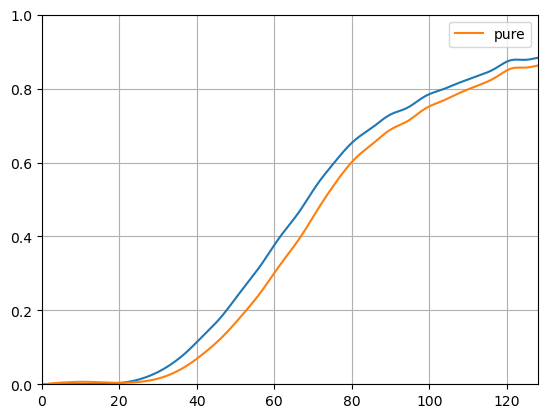

In [5]:
reload(mylib)
fl = mylib.get_fl(cl, pcl, bl, mll, fsky*w2, input_cls[2])
fl_pure = mylib.get_fl(cl, pcl_pure, bl, mll, fsky*w2, input_cls[2])

plt.plot(fl)
plt.plot(fl_pure, label='pure')
plt.xlim([0, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [6]:
# import mylib
# Nl_P = mylib.get_Nl([np.sqrt(2)*3.3, 50, -3], lmax)#/bl**2
# Nl_P = mylib.get_Nl([1, 50, -2], lmax)#/bl**2

# plt.plot(Nl_P)
# plt.loglog()

# noise_cls = np.array([np.zeros_like(Nl_P), Nl_P, Nl_P, np.zeros_like(Nl_P)])

# cl_noise = np.zeros((6, lmax+1))
# cl_noise_pure = np.zeros((6, lmax+1))

# for i in tqdm(range(nmc)):
#     obs_noise = mask_apo*noise[i]
#     cl_noise += hp.anafast(obs_noise)

#     obs_noise[1:] = (pi_b @ obs_noise[1:].flatten()).reshape(2, npix)
#     cl_noise_pure += hp.anafast(obs_noise)
    
#     # # np.random.seed(i+2000)
#     # noise = hp.synfast(noise_cls, nside, new=True)
#     # obs_noise = (R @ noise.flatten()).reshape(3, npix)
#     # # obs_noise = mask_apo * noise
#     # cl_noise += hp.anafast(obs_noise)

#     # obs_noise[1:] = (pi_b @ obs_noise[1:].flatten()).reshape(2, npix)
#     # cl_noise_pure += hp.anafast(obs_noise)

# cl_noise /= nmc
# cl_noise_pure /= nmc
# cl_noise_pol = np.array([cl_noise[1], cl_noise[4], cl_noise[4], cl_noise[2]])
# cl_noise_pure_pol = np.array([cl_noise_pure[1], cl_noise_pure[4], cl_noise_pure[4], cl_noise_pure[2]])

In [7]:
# plt.plot(cl_noise[2])
# plt.plot(cl_noise_pure[2], label='pure')
# # plt.loglog()
# plt.grid()
# plt.legend()
# plt.xlim([20, 2*nside])

In [9]:
nmc_noise = 150

nl = np.empty((nmc_noise, 4, len(ells)))

for i in tqdm(range(nmc_noise)):
    noise = hp.read_map(f'{prefix}/noise/out/{i+1000}/filterbin_filtered_map.fits', field=None)
    f = nmt.NmtField(mask_apo, mask*noise[1:], beam=bl*np.sqrt(fl))
    nl[i] = nmt.compute_full_master(f, f, b)

mean_nl = np.mean(nl, axis=0)
std_nl = np.std(nl, axis=0)

100%|█████████████████████████████████████████████████████████████████| 150/150 [00:09<00:00, 15.95it/s]


/scratch/yuyang/filterbin/mylib.py:81: RuntimeWarning: divide by zero encountered in power
  Nl = n * (l/knee)**alpha + n


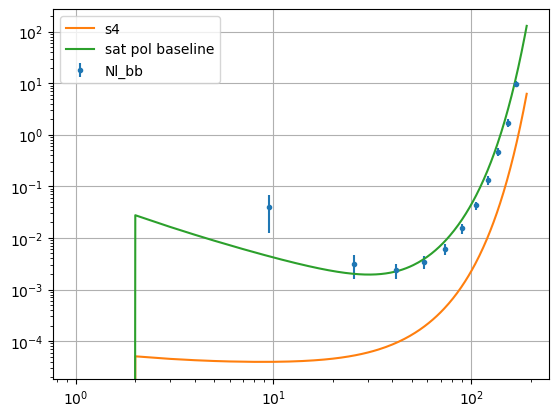

In [10]:
# planck_P_noise_props = [50, 20, -1.4]
# Nl_P_planck = mylib.get_Nl(planck_P_noise_props, lmax)

# lb_P_noise_props = [2.5, 0, 0]
# Nl_P_lb = mylib.get_Nl(lb_P_noise_props, lmax)

sat_pol_baseline = mylib.get_Nl([np.sqrt(2)*3.3, 50, -3], lmax)#/bl**2
# sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 25, -3], lmax)/bl**2
s4 = mylib.get_Nl([1, 50, -2], lmax)#/bl**2

plt.errorbar(ells, c2db*mean_nl[3], yerr=c2db*std_nl[3], fmt='.', label='Nl_bb')
plt.plot(c2d*s4/bl**2, label='s4')
plt.plot(c2d*sat_pol_baseline/bl**2, label='sat pol baseline')

plt.legend()
plt.loglog()
plt.grid()

In [17]:
nmc = 150
cl_KS = np.empty((nmc//2, len(ells)))
cl_restore_planck = np.empty((nmc//2, len(ells)))
cl_restore_lb = np.empty((nmc//2, len(ells)))
cl_matpure = np.empty((nmc//2, len(ells)))

for i in tqdm(range(nmc//2)):
    np.random.seed(i)
    # signal = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    signal = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True) 
    # signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    # np.random.seed(i+200)
    # noise1 = (R_unapo @ hp.synfast(noise_cls, nside, new=True).flatten()).reshape(3,npix)
    # np.random.seed(i+400)
    # noise2 = (R_unapo @ hp.synfast(noise_cls, nside, new=True).flatten()).reshape(3,npix)
    noise1 = hp.read_map(f'{prefix}/noise/out/{i+1000}/filterbin_filtered_map.fits', field=None)
    noise2 = hp.read_map(f'{prefix}/noise/out/{i+1000+nmc//2}/filterbin_filtered_map.fits', field=None)

    obs_signal_unapo = (R_unapo @ signal.flatten()).reshape(3, npix) 
    obs_m1_unapo = obs_signal_unapo + noise1
    obs_m2_unapo = obs_signal_unapo + noise2
    
    #regular KS
    f1 = nmt.NmtField(mask_apo, mask*obs_m1_unapo[1:], beam=bl*np.sqrt(fl), purify_b=True)
    f2 = nmt.NmtField(mask_apo, mask*obs_m2_unapo[1:], beam=bl*np.sqrt(fl), purify_b=True)
    cl_KS[i] = nmt.compute_full_master(f1, f2, b)[3]

    #matrix pure
    obs_m1_apo = mask_apo * obs_m1_unapo #since purification was constructed to apply to apodized maps
    obs_m2_apo = mask_apo * obs_m2_unapo

    pure_QU1 = (pi_b @ obs_m1_apo[1:].flatten()).reshape(2, npix)
    pure_QU2 = (pi_b @ obs_m2_apo[1:].flatten()).reshape(2, npix)
    
    f1 = nmt.NmtField(mask_apo, mask*pure_QU1, beam=bl*np.sqrt(fl_pure), masked_on_input=True)
    f2 = nmt.NmtField(mask_apo, mask*pure_QU2, beam=bl*np.sqrt(fl_pure), masked_on_input=True)
    cl_matpure[i] = nmt.compute_full_master(f1, f2, b)[3]

    # #planck restored
    # restored_map = full[] + planck[i]
    # B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    # f = nmt.NmtField(mask_apo, mask*[B_map])
    # # cl_restore_planck[i] = nmt.compute_full_master(f, f, b, workspace=w_comb)[0]
    # cl_restore_planck[i] = nmt.compute_full_master(f, f, b, [pnl[2]], workspace=w_comb)[0]

    # #lb restored
    # restored_map = full[i] + lb[i]
    # B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
    # f = nmt.NmtField(mask_apo, mask*[B_map])
    # # cl_restore_lb[i] = nmt.compute_full_master(f, f, b, workspace=w_comb)[0]
    # cl_restore_lb[i] = nmt.compute_full_master(f, f, b, [pnl[2]], workspace=w_comb)[0]

mean_KS = c2db * np.mean(cl_KS, axis=0)
std_KS = c2db * np.std(cl_KS, axis=0)

# mean_restore_planck = c2db * np.mean(cl_restore_planck, axis=0)
# std_restore_planck = c2db * np.std(cl_restore_planck, axis=0)

# mean_restore_lb = c2db * np.mean(cl_restore_lb, axis=0)
# std_restore_lb = c2db * np.std(cl_restore_lb, axis=0)

mean_matpure = c2db * np.mean(cl_matpure, axis=0)
std_matpure = c2db * np.std(cl_matpure, axis=0)

100%|███████████████████████████████████████████████████████████████████| 75/75 [00:34<00:00,  2.17it/s]


/tmp/ipykernel_33786/3847088791.py:7: RuntimeWarning: invalid value encountered in sqrt
  knox = (bpw@input_cls[2] + mean_nl[3]) * np.sqrt(2/(bpw@nu_l))


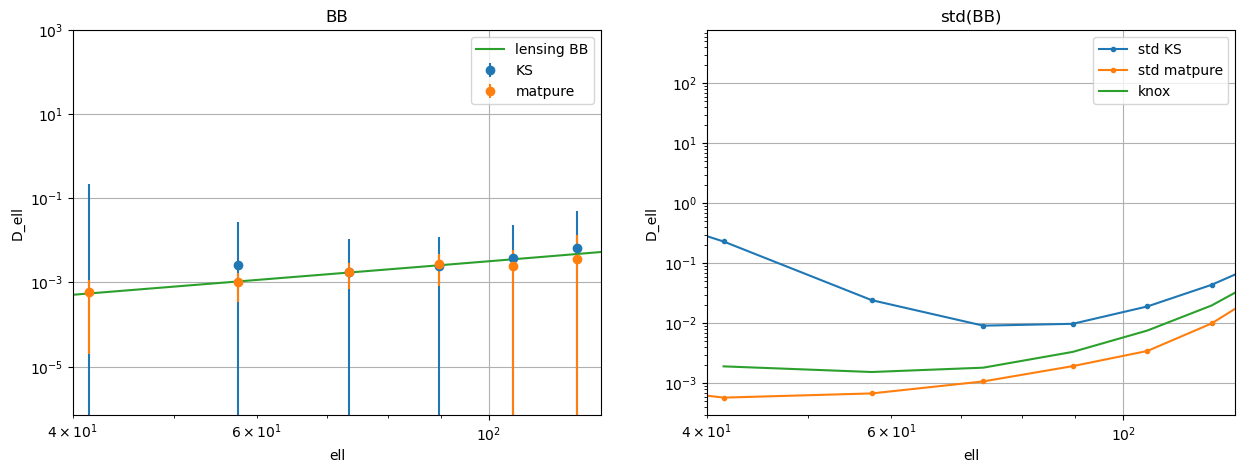

In [18]:
w = nmt.NmtWorkspace()
f = nmt.NmtField(mask_apo, np.empty((1, npix)), beam=bl*np.sqrt(fl))
w.compute_coupling_matrix(f, f, b)
bpw = w.get_bandpower_windows()[0,:,0]

nu_l = (2*np.arange(lmax+1)+1)*fsky*w2**2/w4*bin_size*fl
knox = (bpw@input_cls[2] + mean_nl[3]) * np.sqrt(2/(bpw@nu_l))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(ells, mean_KS, yerr=std_KS, fmt='o', label='KS')
axes[0].errorbar(ells, mean_matpure, yerr=std_matpure, fmt='o', label='matpure')
# axes[0].errorbar(ells, c2db*mean_nl, yerr=c2db*std_nl, fmt='.', label='Nl_bb')
# axes[0].errorbar(ells, mean_restore_planck, yerr=std_restore_planck, fmt='.', label='restore planck')
# axes[0].errorbar(ells, mean_restore_lb, yerr=std_restore_lb, fmt='.', label='restored lb')
axes[0].plot(ell_input, BB, label='lensing BB')
# axes[0].plot(c2d*Nl_P_planck, label='Planck Nl_P', linestyle='dashed')
# axes[0].plot(c2d*Nl_P_lb, label='LB Nl_P', linestyle='dashed')
# axes[0].plot(c2d*cl_noise[2], label='masked filtered BB noise', linestyle='dashed')
# axes[0].plot(c2d*cl_noise_pure[2], label='masked filtered BB noise pure', linestyle='dashed')

axes[0].set_title('BB')

axes[1].plot(ells, std_KS, marker='.',label='std KS')
axes[1].plot(ells, std_matpure, marker='.',label='std matpure')
# axes[1].plot(ells, std_restore_planck, marker='.',label='std restore planck')
# axes[1].plot(ells, std_restore_lb, marker='.',label='std restore lb')
axes[1].plot(ells, c2db*knox, label='knox')
axes[1].set_title('std(BB)')
# axes[1].set_ylim([1e-5,1e0])

for ax in axes.flatten():
    ax.legend()
    ax.set_xlim([40,2*nside])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')

In [ ]:
# import camb
# pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
# pars.WantTensors=True
# pars.InitPower.set_params(r=1)
# results = camb.get_results(pars)
# cl = results.get_tensor_cls(CMB_unit='muK', raw_cl=True)
# cl_r1 = np.pad(np.array([cl[:,i] for i in range(4)]), ((0,0),(0,lmax+1-cl.shape[0])))

In [ ]:
# sigma_r_KS = np.empty(nmc)
# sigma_r_planck = np.empty(nmc)
# sigma_r_lb = np.empty(nmc)

# cl_BB_r1 = bpw@cl_r1[2] 

# for i in range(nmc):
#     sigma_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells+1) * (cl_BB_r1 / cl_KS[i][3])**2 )) 
#     sigma_r_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells+1) * (cl_BB_r1 / cl_restore_planck[i][3])**2 )) 
#     sigma_r_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells+1) * (cl_BB_r1 / cl_restore_lb[i][3])**2 )) 

In [ ]:
# plt.hist(sigma_r_KS, label='KS', alpha=0.75, edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_planck, label='planck', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_lb, label='lb', alpha=0.75,edgecolor='black', linewidth=0.5)

# plt.legend()
# # plt.ylim([0, 40])
# # plt.grid()
# plt.xlabel('sigma(r)')
# plt.ylabel('# MC')

In [ ]:
# np.median(sigma_r_KS), np.median(sigma_r_planck), np.median(sigma_r_lb)